In [1]:
#!/usr/bin/python
import sys
import pickle
import pandas as pd
import numpy as np
import random
import collections, operator
import seaborn as sea
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
%matplotlib inline

sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
import explore_data

import warnings
warnings.filterwarnings('ignore')



/Users/akshitmeghawat/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# full list

"""Task 1: Select features features_list is a list of strings, 
each of which is a feature name. The first feature is "poi"."""

features_list = [
    'poi',
    'salary',
    'to_messages',
    'deferral_payments',
    'total_payments',
    'exercised_stock_options',
    'bonus',
    'restricted_stock',
    'shared_receipt_with_poi',
    'restricted_stock_deferred',
    'total_stock_value',
    'expenses',
    'loan_advances',
    'from_messages',
    'other',
    'from_this_person_to_poi',
    'director_fees',
    'deferred_income',
    'long_term_incentive',
    'from_poi_to_this_person',
    ]

### Load the dictionary containing the dataset

with open('final_project_dataset.pkl', 'r') as data_file:
    data_dict = pickle.load(data_file)

df = pd.DataFrame.from_dict(data_dict, orient='index')
df = df.replace('NaN', np.nan)

### Explore data
print('####### Explore Data #########')

from explore_data import find_highest_paid, count_valid_values
count_valid_values(data_dict)
print ''
print 'Count of people: ', len(data_dict)
poiCount = sum(p['poi'] == 1 for p in data_dict.values())
print 'Count of POIs: ', poiCount
# visualize_data(data_dict, features_list)

# print 'Missing data in each column'
# print df.isnull().sum()

####### Explore Data #########
Valid values: 
{'bonus': 82,
 'deferral_payments': 39,
 'deferred_income': 49,
 'director_fees': 17,
 'email_address': 111,
 'exercised_stock_options': 102,
 'expenses': 95,
 'from_messages': 86,
 'from_poi_to_this_person': 86,
 'from_this_person_to_poi': 86,
 'loan_advances': 4,
 'long_term_incentive': 66,
 'other': 93,
 'poi': 146,
 'restricted_stock': 110,
 'restricted_stock_deferred': 18,
 'salary': 95,
 'shared_receipt_with_poi': 86,
 'to_messages': 86,
 'total_payments': 125,
 'total_stock_value': 126}

Count of people:  146
Count of POIs:  18


,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
KAMINSKI WINCENTY J,275101.0,4607.0,NaN,1086821.0,850010.0,400000.0,126027.0,583.0,NaN,976037.0,...,NaN,14368.0,4669.0,171.0,False,NaN,NaN,323466.0,vince.kaminski@enron.com,41.0


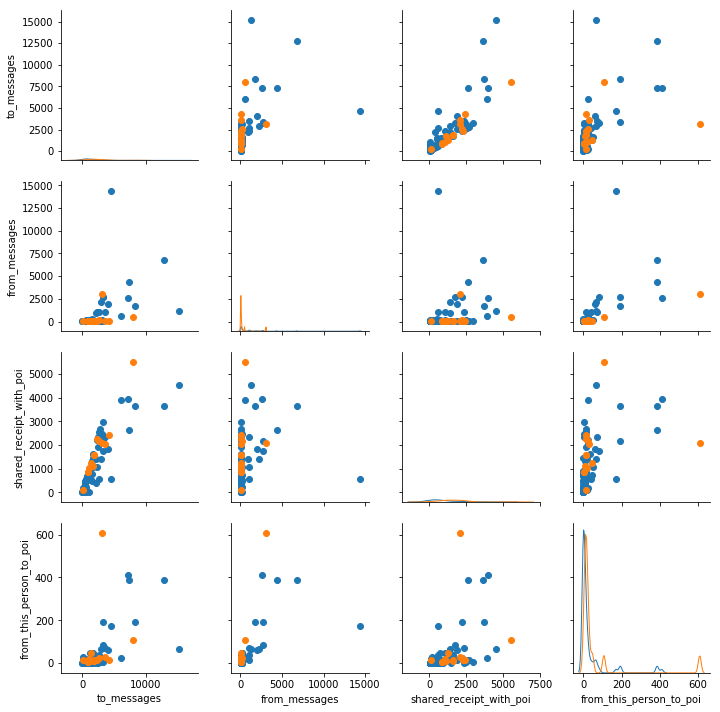

In [3]:
"""Task 2: Remove outliers
"""
df[df.salary > 2.0e7]
df[df.total_payments > 0.8e7]

g = sea.PairGrid(df, vars=['to_messages','from_messages','shared_receipt_with_poi','from_this_person_to_poi' ],
                hue='poi')
g.map_lower(plt.scatter)
g.map_upper(plt.scatter)
g.map_diag(sea.kdeplot, lw=1)
df[df.from_messages > 12000]

In [4]:
### Remove Outliers data_dict dropping: (is this necessary if convert back to_dict at end?)
outliers = ['TOTAL', 'THE TRAVEL AGENCY IN THE PARK', 'KAMINSKI WINCENTY J']
for outlier in outliers:
    data_dict.pop(outlier, 0)

In [5]:
### Correct data for Bhatnagar Sanjay

b_sandjay = data_dict['BHATNAGAR SANJAY']
b_sandjay['expenses'] = 137864
b_sandjay['total_payments'] = 137864
b_sandjay['exercised_stock_options'] = 15456734
b_sandjay['restricted_stock'] = 2604490
b_sandjay['restricted_stock_deferred'] = 2604490
b_sandjay['total_stock_value'] = 15456290
b_sandjay['director_fees'] = 'NaN'
b_sandjay['other'] = 'NaN'

### Correct data for B Robert
b_robert = data_dict["BELFER ROBERT"]
b_robert['deferred_income'] = 102500
b_robert['deferral_payments']= 'NaN'
b_robert['expenses'] = 3285
b_robert['directors_fees'] = 102500
b_robert['total_payments']=3285
b_robert['exercised_stock_options']='NaN'
b_robert['restricted_stock_options']=44093

In [6]:
'''Task 3: Create new features'''
for name in data_dict:
    to_messages = data_dict[name]['to_messages']
    from_messages = data_dict[name]['from_messages']
    to_user_from_poi = data_dict[name]['from_poi_to_this_person']
    from_user_to_poi = data_dict[name]['from_this_person_to_poi']
    shared_receipt = data_dict[name]['shared_receipt_with_poi']

    if to_messages != 'NaN' and to_user_from_poi != 'NaN':
        ratio_from_poi = float(to_user_from_poi)/float(to_messages)
    else:
        ratio_from_poi = 'NaN'
    if from_messages != 'NaN' and from_user_to_poi != 'NaN':
        ratio_to_poi = float(from_user_to_poi)/float(from_messages)
    else:
        ratio_to_poi = 'NaN'
    if to_messages != 'NaN' and shared_receipt != 'NaN':
        ratio_shared_receipt = float(shared_receipt)/float(to_messages)
    else:
        ratio_shared_receipt = 'NaN'
 
    data_dict[name]['ratio_from_poi'] = ratio_from_poi
    data_dict[name]['ratio_to_poi'] = ratio_to_poi
    data_dict[name]['ratio_shared_receipt'] = ratio_to_poi

In [7]:
### Feature scaling
minmax_features = {}

for key in data_dict:
    for feature in features_list:
        feature_value = data_dict[key][feature]
        if feature_value != 'NaN':
            if not minmax_features.has_key(feature):
                minmax_features[feature] = \
                    {"min":feature_value,"max":feature_value}
            elif feature_value > minmax_features[feature]["max"]:
                minmax_features[feature]["max"]=feature_value
            elif feature_value < minmax_features[feature]["min"]:
                minmax_features[feature]["min"]=feature_value

for key in data_dict:
    for feature in features_list:
        feature_value = data_dict[key][feature]
        if feature != "poi" and feature_value != 'NaN':
            feature_value = data_dict[key][feature]
            minmax = minmax_features[feature]
            mrange = minmax['max']-minmax['min']
            feature_value = feature_value - minmax['min']
            feature_value = float(feature_value) / float(mrange)
            data_dict[key][feature] = feature_value

In [8]:
### Store to my_dataset for easy export below.
my_dataset = data_dict
# Convert dictionary to numpy array, converts NaN to 0.0  
# data = featureFormat(my_dataset, features_list, sort_keys = True, remove_all_zeroes = False)
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

### Adaboost

In [9]:
random.seed(0)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)

In [11]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [12]:
def check_purity(y):
    unique_classes = np.unique(y)
    if len(unique_classes)==1:
        return True
    else:
        return False

In [17]:
def classify_data(y, w):
    dictionary = collections.defaultdict(float)
    for i in range(len(y)):
        dictionary[y[i]] += w[i]
    return max(dictionary.iteritems(), key=operator.itemgetter(1))[0]

In [14]:
def get_potential_splits(X):
    _,n = X.shape
    potential_splits = {}
    for i in range(n):
        # print i
        unique_values = np.unique(X[:,i])
        splits = []
        # print unique_values
        for j in range(1,len(unique_values)):
            splits.append((unique_values[j]+unique_values[j-1])/2.0)
        # print splits
        potential_splits[i] = splits
    return potential_splits

In [15]:
def split_data(X, y, split_column, threshold, w):
    below_rows = np.where(X[:,split_column]<=threshold)[0]
    # print below_rows
    above_rows = range(X.shape[0])
    above_rows = np.setdiff1d(above_rows, below_rows)
    # print above_rows
    X_below = X[below_rows,:]
    y_below = y[below_rows]
    w_below = w[below_rows]
    X_above = X[above_rows,:]
    y_above = y[above_rows]
    w_above = w[above_rows]
    return X_below, X_above, y_below, y_above, w_below, w_above

In [16]:
def split_y(X, y, split_column, threshold, w):
    below_rows = np.where(X[:,split_column]<=threshold)[0]
    above_rows = range(X.shape[0])
    above_rows = np.setdiff1d(above_rows, below_rows)
    y_below = y[below_rows]
    w_below = w[below_rows]
    y_above = y[above_rows]
    w_above = w[above_rows]
    return y_below, y_above, w_below, w_above

In [18]:
def calculate_entropy(y, weights):
    probabilities = collections.defaultdict(float)
    for i in range(len(y)):
        probabilities[y[i]] += weights[i]
    p = []
    for key, value in probabilities.iteritems():
        p.append(value/np.sum(weights))
    entropy = -1*(np.sum(p*np.log2(p)))
    return entropy

In [19]:
def calculate_overall_entropy(y_below, y_above, weights_below, weights_above):
    overall_entropy = (np.sum(weights_below)*calculate_entropy(y_below, weights_below) + np.sum(weights_above)*calculate_entropy(y_above, weights_above)) / (np.sum(weights_below)+np.sum(weights_above))
    return overall_entropy

In [20]:
def determine_best_split(X, y, w):
    potential_splits = get_potential_splits(X)
    split_column = None
    split_threshold = None
    min_overall_entropy = 999
    for column, splits in potential_splits.iteritems():
        for threshold in splits:
            y_below, y_above, w_below, w_above = split_y(X, y, column, threshold, w)
            overall_entropy = calculate_overall_entropy(y_below, y_above, w_below, w_above)
            if overall_entropy < min_overall_entropy:
                split_column = column
                split_threshold = threshold
                min_overall_entropy = overall_entropy
    return split_column, split_threshold

In [23]:
class DecisionTreeClassifier:
    def __init__(self, min_samples = 10, max_depth = 3):
        self.is_leaf = False
        self.leaf_value = None
        self.below = None
        self.above = None
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.split_column = None
        self.split_threshold = None
    def fit(self, X, y, w):
        if len(y)<=self.min_samples or check_purity(y) or self.max_depth == 0:
            self.is_leaf = True
            self.leaf_value = classify_data(y, w)
        else:
            split_column, split_threshold = determine_best_split(X, y, w)
            self.split_column = split_column
            self.split_threshold = split_threshold
            X_below, X_above, y_below, y_above, w_below, w_above = split_data(X, y, split_column, split_threshold, w)
            self.below = DecisionTreeClassifier(self.min_samples, self.max_depth - 1)
            self.below.fit(X_below, y_below, w_below)
            self.above = DecisionTreeClassifier(self.min_samples, self.max_depth - 1)
            self.above.fit(X_above, y_above, w_above)
    def predict(self, x):
        if self.is_leaf:
            return self.leaf_value
        else:
            if x[self.split_column] <= self.split_threshold:
                return self.below.predict(x)
            else:
                return self.above.predict(x)

### Adaboost loop

In [33]:
M = 10

n_train = len(X_train)
# Initialize weights
w = np.ones(n_train) / n_train
classifiers = [None for _ in range(M)]
alpha = [None for _ in range(M)]
pred_train = np.zeros(n_train)

y_prev = y_train
for i in range(M):
    # Fit a classifier with the specific weights
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train, w)
    classifiers[i] = clf
    predictions = []
    for row in X_train:
        predictions.append(clf.predict(row))
    
    miss = [int(x) for x in (predictions != y_train)]
    miss2 = [x if x==1 else 0 for x in miss]
    err_m = np.dot(w,miss) / sum(w)
    # Alpha
    alpha_m = 0.5 * np.log( (1 - err_m) / float(err_m))
    alpha[i]=alpha_m
    # New weights
    w = np.multiply(w, np.exp([float(x) * alpha_m for x in miss2]))
    # Add to prediction
    pred_train = [sum(x) for x in zip(pred_train, 
                                      [x * alpha_m for x in predictions])]

In [34]:
final_predictions = []
for row in X_test:
    pred = 0
    for i in range(M):
        pred += alpha[i]*(classifiers[i].predict(row))
    final_predictions.append(pred>0)

In [35]:
# final_predictions
print classification_report(y_true=y_test, y_pred=final_predictions)

             precision    recall  f1-score   support

        0.0       1.00      0.20      0.33        25
        1.0       0.17      1.00      0.29         4

avg / total       0.89      0.31      0.33        29

